### Build a Simple Recommender System Using "Surprise"

This is a Jupyter Notebook. When you execute code within the notebook, the results appear beneath the code. To execute a code chunk, place your cursor on the cell and press Shift+Enter.

Recommender Systems are used to predict user preferences or we can say that these are systems that help people find things when the manual process of selection is a little bit challenging because of too many choices or alternatives. The best examples are Amazon recommending us the next book to read or Netflix suggesting the next movie to watch.
There are three types of recommender systems.
<ul>
    <li>Collaborative filtering</li>
    <li>Content-based filtering</li>
    <li>Hybrid recommender system</li>
</ul>
We are going to build a recommender system using the collaborative filtering technique. 
Collaborative filtering is the technique of making predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating).

[Surprise](https://github.com/NicolasHug/Surprise) is a Python [scikit](https://www.scipy.org/scikits.html) for building and testing recommender systems that deal with explicit rating data. 
We will make use of this library for building the collaborative filtering based recommender system.

### Installation

You can install Surprise on your machine using pip cor conda. You'll also need numpy and a C compiler. The recommended method for windows users is using conda):

In [19]:
!pip install numpy
!pip install scikit-surprise
!pip install pandas
!pip install matplotlib
!pip install seaborn

With conda

In [20]:
#!conda install -c conda-forge scikit-surprise

### Import Libraries

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import SVD, accuracy

### Load Data

We are going to use the Amazon's clothing, shoes and jewellery rating dataset from [here](https://jmcauley.ucsd.edu/data/amazon/)

In [22]:
colnames=['reviewerID', 'asin', 'overall', 'unixReviewTime'] 
data = pd.read_csv('./data/ratings.csv', names=colnames, header=None)
data.head()

,reviewerID,asin,overall,unixReviewTime
0,A2XVJBSRI3SWDI,0000031887,5.0,1383523200
1,A2G0LNLN79Q6HR,0000031887,4.0,1337990400
2,A2R3K1KX09QBYP,0000031887,2.0,1361059200
3,A19PBP93OF896,0000031887,1.0,1363824000
4,A1P0IHU93EF9ZK,0000031887,4.0,1390435200


As you can see the data is loaded using pandas. We have four columns reviewerID, asin, overall and unixReviewTime.<br/>

where
<ul>
    <li>reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B</li>
    <li>asin - ID of the product, e.g. 0000013714</li>
    <li>overall - rating of the product</li>
    <li>unixReviewTime - time of the review (unix time)</li>
</ul>

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5748920 entries, 0 to 5748919
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   reviewerID      object 
 1   asin            object 
 2   overall         float64
 3   unixReviewTime  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 175.4+ MB


The dataset contains 5748920 rows of data. Now we will check the value counts of the column overall.

In [24]:
data.overall.value_counts()

5.0    3303450
4.0    1120583
3.0     574597
1.0     396523
2.0     353767
Name: overall, dtype: int64

We can see that the rating of 5.0 has the highest value counts. This means more people rated an item 5.0. It is shown in the plot below.

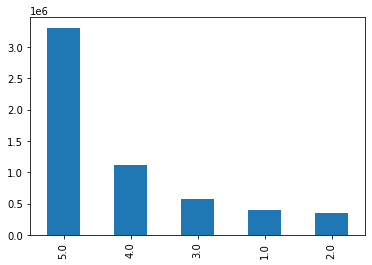

In [25]:
data.overall.value_counts().plot(kind='bar')
plt.show()

Now we will check for null values in the dataset.

In [26]:
data.isnull().sum()

reviewerID        0
asin              0
overall           0
unixReviewTime    0
dtype: int64

As there are no null values in the dataset we will jump into the next step.

### Load Data into Surprise

We don't need the timestamp column for this. So we will remove that column from the dataset.

In [27]:
data = data[['reviewerID', 'asin', 'overall', 'unixReviewTime']]
input_data = data.iloc[:, :-1]
input_data.head()

,reviewerID,asin,overall
0,A2XVJBSRI3SWDI,0000031887,5.0
1,A2G0LNLN79Q6HR,0000031887,4.0
2,A2R3K1KX09QBYP,0000031887,2.0
3,A19PBP93OF896,0000031887,1.0
4,A1P0IHU93EF9ZK,0000031887,4.0


To load the dataset from pandas data frame to Surprise, we will use the load_from_df() method. We will also need a Reader object with the rating_scale the parameter specified as (1,5).

In [28]:
reader = Reader(rating_scale=(1,5))
input_data = Dataset.load_from_df(input_data[['reviewerID', 'asin', 'overall']], reader)

Now we will split the input_data to train and test data in an 80:20 ratio.

In [29]:
train_data, test_data = train_test_split(input_data, test_size=0.20)

The most known and widely used matrix decomposition method is the Singular-Value Decomposition or SVD. All matrices have an SVD, which makes SVD more stable than other methods. So we will use this technique for training our model.

In [ ]:
algo = SVD()
predictions = algo.fit(train_data).test(test_data)

In [ ]:
accuracy.rmse(predictions)
accuracy.mae(predictions)
accuracy.mse(predictions)

To inspect our predictions in details, we are going to build a pandas data frame with all the predictions. The following code is largely taken from this [notebook](https://nbviewer.jupyter.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb).

In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(train_data.ur[train_data.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(train_data.ir[train_data.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:1000]
worst_predictions = df.sort_values(by='err')[-1000:]

In [ ]:
best_predictions

In [ ]:
worst_predictions

Here rui is the actual user rating while est is the value predicted by our model.

That's it! We build a fashion apparel recommender system using the Surprise library. You can perform hyperparameters tuning and Cross-validation with Surprise to get more accurate predictions. You can find the official Surprise documentation [here](https://surprise.readthedocs.io/en/stable/index.html).
I love your feedback, please let me know what you think.